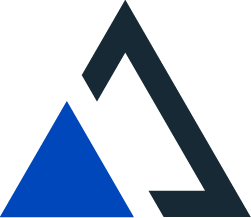

<h1><font color='#0047BB'>Feature Importance</font></h1>

<h3><font color='#0047BB'>Introduction</h3>

[Feature importance](https://en.wikipedia.org/wiki/Feature_selection) is a measure of how much influence a given feature has on the output of a machine learning model. It’s an important measure not only because it indicates which (if any) features are irrelevant and can be excluded from the model, but also because it indicates which (if any) features are of outsize importance in determining model output. And when model output is a quantity that’s critical for an organization’s health – e.g., forecasted sales – it’s valuable to understand what its best predictors are.

AI-Link allows users to write feature importance scores for their models back to AtScale. This allows model builders and consumers alike to understand how the model’s input features relate to its output.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from atscale.client import Client
from atscale.db.connections.snowflake import Snowflake

<h3><font color='#0047BB'>Connect to AtScale</h3>

In [3]:
client = Client(
    server=...,
    username=...,
    organization=...,
)

client.connect()

project = client.select_project(
    draft_project_id=...,
)

data_model = project.select_data_model(
    data_model_id=...,
)

Please choose a published project:
Automatically selecting only option: "ID: d33bda47-64f2-4600-5138-d9585e2620c0: Name: Sales Insights"
Please choose a data model:
Automatically selecting only option: "ID: b89a2fb7-74f4-4828-706e-70f7186e10a0: Name: Internet Sales Cube"


<h3><font color='#0047BB'>Connect to Data Warehouse</h3>

In [4]:
db = Snowflake(
    username=...,
    password=...,
    account=...,
    warehouse=...,
    database=...,
    schema=...,
    warehouse_id=...,
)

<h3><font color='#0047BB'>Get Data From Your AtScale Data Model</h3> 

For this example, we'll assume that we have week-wise customer count and sales data for years prior to 2008. We also have the week-wise standard deviation of the sales data in that period (we'll soon see how relevant this is).

Our goal is to forecast the sales data for 2008 with a predictive model.

In [5]:
df = data_model.get_data(
    feature_list=[
        "Order Week",
        "customercount1",
        "salesamountsstdev1",
        "salesamount1",
    ],
    filter_less={"Order ReportIng_Year": "Reporting Calendar 2008"},
)

<h3><font color='#0047BB'>Train Your Model</h3> 

In the below cell, we train a linear regression model to forecast sales as a function of customer count and the standard deviation of the sales data. (Assume for the sake of this exercise that we have the standard deviation of the sales data, but not the sales data itself.)

In [6]:
# convert data to NumPy arrays
X = df[["customercount1", "salesamountsstdev1"]].to_numpy()

y = df[["salesamount1"]].to_numpy()

# split data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=7
)

# train model
regression_model = LinearRegression().fit(X_train, y_train)

# evaluate model on test data
print(f"R^2 score on test data: {regression_model.score(X_test, y_test)}")

R^2 score on test data: 0.8347532581867798


<h3><font color='#0047BB'>Determine Feature Importance</h3> 

Of the two features being passed to the model, which of them are actually helpful for predicting sales? We'll use [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) to answer that question. At a high level, this technique determines which features matter to the model by shuffling the order of each feature's values that are passed to the model. If shuffling their order doesn't change much about the model output, then the feature probably isn't as important. But if shuffling their order hurts the model's performance, that feature is likely important for making predictions.

In [7]:
importance = permutation_importance(
    regression_model, 
    X_test, 
    y_test, 
    n_repeats=15, 
    random_state=0,
)

In [8]:
feature_importance_df = pd.DataFrame({
        "customercount1": [importance["importances_mean"][0]],
        "salesamountsstdev1": [importance["importances_mean"][1]]
})

In [9]:
feature_importance_df

customercount1  salesamountsstdev1
0         1.62044            0.063228

We see (perhaps unsurprisingly) that the number of customers in a given period is much more important when predicting sales than the standard deviation of the sales numbers themselves. But we're not done – we can write these feature importance scores to AtScale for users across our organization to see.

<h3><font color='#0047BB'>Write Feature Importance to AtScale Model</h3> 

AI-Link provides functionality to write the DataFrame containing our feature importance scores to AtScale. After defining the name of the will-be feature importance table in AtScale and the feature name prefix:

In [10]:
feat_import_table_name = "EXAMPLE_FEATURE_IMPORTANCE_TABLE"
feat_prefix = "FEAT_IMPORT_"

we're free to write the feature importance scores to AtScale with a single function call:

In [11]:
data_model.write_feature_importance(
    dbconn=db,
    table_name=feat_import_table_name,
    dataframe=feature_importance_df,
    feature_name_prefix=feat_prefix,
)

09/05/2024 04:20:25 PM WARNING:Column name: customercount1 appears as CUSTOMERCOUNT1
09/05/2024 04:20:25 PM WARNING:Column name: salesamountsstdev1 appears as SALESAMOUNTSSTDEV1
09/05/2024 04:20:27 PM WARNING:Column name: customercount1 appears as CUSTOMERCOUNT1
09/05/2024 04:20:27 PM WARNING:Column name: salesamountsstdev1 appears as SALESAMOUNTSSTDEV1
09/05/2024 04:20:27 PM WARNING:Column name: customercount1 appears as CUSTOMERCOUNT1
09/05/2024 04:20:27 PM WARNING:Column name: salesamountsstdev1 appears as SALESAMOUNTSSTDEV1
09/05/2024 04:20:28 PM WARNING:Column name: customercount1 appears as CUSTOMERCOUNT1
09/05/2024 04:20:28 PM WARNING:Column name: salesamountsstdev1 appears as SALESAMOUNTSSTDEV1
